In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import floor


##Helper functions

In [2]:
# get_img_intensity is a helper function to obtain the image intensity of an image 
# at a given coordinate if it exists
def get_img_intensity(img,x,y):
    assert len(img.shape)==2 # Checking if image shape is 2D
    # Checking if x and y are integers
    assert isinstance(x,int) 
    assert isinstance(y,int)
    if x<0 or x>=img.shape[0] or y<0 or y>=img.shape[1]:
        return 0
    else:
        return img[x,y]

# get_bilinear_interpolation_intensity takes source_image, x and y coordinates(possibly in decimals)
# and calculates intensity using Bilinear Interpolation from the image
def get_bilinear_interpolation_intensity(img_source,xs,ys):
    assert len(img_source.shape)==2
    xsd,ysd = int(floor(xs)),int(floor(ys))
    a,b = xs - xsd, ys - ysd
    return int((1-a)*(1-b)*get_img_intensity(img_source,xsd,ysd) + \
           (a)*(1-b)*get_img_intensity(img_source,xsd+1,ysd) + \
           (1-a)*(b)*get_img_intensity(img_source,xsd,ysd+1) + \
           (a)*(b)*get_img_intensity(img_source,xsd+1,ysd+1))

##Solution

The second image is obtained after roation and translation of the first image. \
After solving for rotation and translation of coordinates(xs,ys) of the source image we have the equations: \
xt = xs cosϴ + ys sinϴ + Tx \
yt = -xs sinϴ + ys cosϴ + Ty \

Simplifying the above equations for both the points of correspondence: \
xt2-xt1 = (xs2 - xs1)cosϴ + (ys2 - ys1)sinϴ \
yt2-yt1 = (xs1 - xs2)sinϴ + (ys2 - ys1)cosϴ \
\
We determine ϴ from the above equations and then solve for Tx and Ty from ϴ obtained. There are two solutions for each of the 2 equations above. We will choose the solution common to both the equations.

\
To solve each equation for ϴ, we take the eqn acosϴ + bsinϴ + c = 0. Solving we get,\
ϴ = ±arccos(-c/sqrt(a^2+b^2)) + arctan(b,a)


In [3]:
# Data from the question
xs1,ys1 = 29,124
xt1,yt1 = 93,248
xs2,ys2 = 157,372
xt2,yt2 = 328,399

In [4]:
# Using the results for ϴ after solving acosϴ + bsinϴ + c = 0
a = xs2 - xs1
b = ys2 - ys1
c = xt1 - xt2
theta1 = np.arccos(-c/np.sqrt(a**2+b**2)) + np.arctan2(b,a)
theta2 = -np.arccos(-c/np.sqrt(a**2+b**2)) + np.arctan2(b,a)
print("ϴ = [%f,%f] are the two solutions from equation 1"%(theta1, theta2))

ϴ = [1.664072,0.524586] are the two solutions from equation 1


In [5]:
a = ys2 - ys1
b = xs1 - xs2
c = yt1 - yt2
theta3 = np.arccos(-c/np.sqrt(a**2+b**2)) + np.arctan2(b,a)
theta4 = -np.arccos(-c/np.sqrt(a**2+b**2)) + np.arctan2(b,a)
print("ϴ = [%f,%f] are the two solutions from equation 2"%(theta3, theta4))

ϴ = [0.522637,-1.475572] are the two solutions from equation 2


It is clear that ϴ = 0.523(approx) radians is the value which satisfies both equations. Therefore, we use this value of theta to solve for Tx and Ty.

In [6]:
ϴ = 0.523
Tx = xt1 - xs1*np.cos(ϴ) - ys1*np.sin(ϴ)
Ty = yt1 + xs1*np.sin(ϴ) - ys1*np.cos(ϴ)
print("ϴ = ", ϴ)
print("Tx = ", Tx)
print("Ty = ", Ty)

ϴ =  0.523
Tx =  5.940897462504147
Ty =  155.06070440676996


From the above results it is clear that img1 has to be rotated by 0.523 radians or ~30 degrees clockwise and then translated by ~(6,155) pixels to obtain img2

##Verification

In [7]:
def transform_coordinate(xs, ys, theta, Tx, Ty):
  xt = xs*np.cos(theta) + ys*np.sin(theta) + Tx
  yt = -xs*np.sin(theta) + ys*np.cos(theta) + Ty
  
# We cross check the results by verifying that the obtained transformation leads
#  to correct points of correspondences given in the question.
transform_coordinate(xs=29, ys=124, theta=0.523, Tx=6, Ty=155)
transform_coordinate(xs=157, ys=372, theta=0.523, Tx=6, Ty=155)


Here we notice indeed that the results obtained agree with the given points of correspondences and result in the correct coordinates of the transformed image.

\
We now plot the transformed image given and the image obtained by us after performing the obtained transformation.

In [8]:
img1 = cv2.imread('/content/drive/MyDrive/EE5175/Lab_2/IMG1.png',0)
img2 = cv2.imread('/content/drive/MyDrive/EE5175/Lab_2/IMG2.png',0)
(l,w) = img1.shape

ϴ = np.deg2rad(30) # Convert to radians
Tx,Ty = 6,155
transMat = np.array([[np.cos(ϴ),np.sin(ϴ),Tx],[-np.sin(ϴ),np.cos(ϴ),Ty],[0,0,1]])
transMatInv = np.linalg.inv(transMat) # Find inverse of the transformation matrix

transformed_img = np.zeros((517,598))
for i in range(transformed_img.shape[0]):
    for j in range(transformed_img.shape[1]):
        # Transform the target image coordinates to obtain the source img coordinates
        [i_s,j_s] = (transMatInv @ np.array([i,j,1]))[:2]
        # Perform bilinear interpolation to find the target image intensity for each pixel
        transformed_img[i,j] = get_bilinear_interpolation_intensity(img1,i_s,j_s)



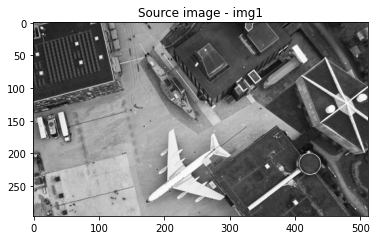

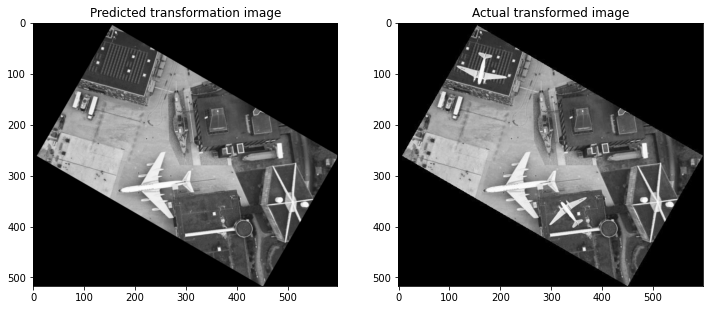

In [9]:
# Plot images
fig, ax = plt.subplots(1, 1,figsize=(6,6))
ax.set_title("Source image - img1")
ax.imshow(img1,cmap="gray")
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,12))
# ax1.set_axis_off()
# ax2.set_axis_off()
ax1.set_title("Predicted transformation image")
ax2.set_title("Actual transformed image")
ax1.imshow(transformed_img,cmap='gray')
ax2.imshow(img2,cmap='gray')

The first image is the image captured by the first camera.
\
The second shows the transformed image after rotation by 30 degrees and translation by (6,155) pixels, while the third image shows the actual transformed image taken by the second camera.